# **Introduction**
## **Research Title**
**Forecasting Bitcoin Price Movements Using GRU-Attention Networks and Sentiment-Enhanced Features.**

## **Research Question**
**Can the integration of sentiment analysis with GRU-Attention neural networks improve the predictive accuracy of forecasting future Bitcoin price movements, and how do these sentiment features contribute to the model's interpretability?**

This notebook details the complete, end-to-end machine learning pipeline developed to address the research question.

The pipeline is structured into the following key stages:

* **Environment Setup**: All necessary libraries for data processing, deep learning, and statistical modeling are installed and imported.

* **Data Loading & Preprocessing**: Raw datasets are loaded, aligned chronologically, and a crucial check for data leakage is performed.

* **Feature Engineering**: Data is transformed to create a suitable target variable and predictor features.

* **Model Training**: A GRU-Attention model is built and trained to forecast Bitcoin price movements.

* **Baseline Comparisons**: The hybrid model's performance is evaluated against simpler baseline models.

* **Evaluation & Interpretation**: Model performance is analyzed using appropriate metrics, and key insights into the contribution of sentiment features are provided.

The implementation of this pipeline serves as the technical contribution of my applied research project. All code and a detailed explanation of the methodology are provided for full reproducibility.

The datasets used in this project were sourced from:
* BTC Prices: https://github.com/mouadja02/bitcoin-hourly-ohclv-dataset

* Sentiment data: https://www.augmento.ai/download/2317/



# Step 1: Environment Setup
All necessary libraries for data processing, deep learning, and statistical modeling are installed and imported in this single block. Importing all required libraries at the beginning of the notebook is a best practice that ensures code clarity and prevents NameError issues in subsequent cells. The standard aliases (pd, np) are used for readability, and known warnings are suppressed to keep the output clean.

In [1]:
# This code cell installs and imports all required libraries for the project.

# Install libraries
!pip install --quiet numpy pandas scikit-learn tensorflow arch matplotlib seaborn

# Suppress known warnings for a cleaner output
import warnings
from arch.__future__ import reindexing
from arch.univariate.base import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Activation, dot, Concatenate, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import jarque_bera

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 14.4 MB/s eta 0:00:00


# Step 2: Data Loading
>The two primary datasets for this project—hourly Bitcoin OHLCV (Open, High, Low, Close, Volume) and hourly sentiment scores—are loaded from Google Drive. The data is read into pandas DataFrames, which provide a flexible and powerful structure for data manipulation. Loading the data into separate DataFrames allows each dataset's unique structure and contents to be inspected before they are merged.

In [2]:
# This code cell loads the BTC OHLCV and sentiment data from Google Drive into pandas DataFrames.
# We will inspect the first few rows and the data types to ensure a successful load.

# Define the file paths to the datasets on Google Drive
file_path_btc = '/content/drive/MyDrive/Dissertation_Data/btc_prices.csv'
file_path_sentiment = '/content/drive/MyDrive/Dissertation_Data/sentiment.csv'

# Load the datasets
btc_df = pd.read_csv(file_path_btc)
sentiment_df = pd.read_csv(file_path_sentiment)

# Display the first 5 rows of each DataFrame
print("Bitcoin Price Data (First 5 rows):")
print(btc_df.head())
print("\n" + "="*50 + "\n")

print("Sentiment Data (First 5 rows):")
print(sentiment_df.head())
print("\n" + "="*50 + "\n")

# Display a summary of the DataFrames, including column names and data types
print("Bitcoin Price Data Info:")
btc_df.info()
print("\n" + "="*50 + "\n")

print("Sentiment Data Info:")
sentiment_df.info()

Bitcoin Price Data (First 5 rows):
    TIME_UNIX  DATE_STR  HOUR_STR  OPEN_PRICE  HIGH_PRICE  CLOSE_PRICE  \
0  1416031200  15-11-14         6      395.88      398.12       396.15   
1  1416034800  15-11-14         7      396.15      397.49       397.15   
2  1416038400  15-11-14         8      397.15      399.99       399.90   
3  1416042000  15-11-14         9      399.90      399.90       392.56   
4  1416045600  15-11-14        10      392.56      393.10       391.83   

   LOW_PRICE  VOLUME_FROM  VOLUME_TO  
0     394.43       459.60  182309.81  
1     395.96       428.88  170256.62  
2     396.91       445.96  178280.48  
3     391.83       494.09  195473.98  
4     390.03       437.84  171654.03  


Sentiment Data (First 5 rows):
                  date  listing_close  twitter_hacks  \
0  2016-11-01 23:00:00         726.60            0.0   
1  2016-11-02 00:00:00         721.96            0.0   
2  2016-11-02 01:00:00         722.49            0.0   
3  2016-11-02 02:00:00       

# Step 3: Data Alignment and Merging
>The two datasets must be aligned and merged into a single DataFrame before any further analysis. This is a fundamental step in any time-series analysis involving multiple data sources. The process involves converting the date columns to a standardized datetime format, extracting common date and hour components, and then performing an inner merge to ensure only the shared time periods are included. This guarantees a consistent and complete dataset for subsequent feature engineering and modeling.

In [3]:
# This code cell aligns and merges the two DataFrames based on hourly timestamps.
# The `how='inner'` merge ensures that only the time points present in both datasets are kept.

# Convert the relevant date columns to datetime objects
btc_df['DATETIME_KEY'] = pd.to_datetime(
    btc_df['DATE_STR'].astype(str) + ' ' + btc_df['HOUR_STR'].astype(str),
    format='%d-%m-%y %H'
)
sentiment_df['DATETIME_KEY'] = pd.to_datetime(sentiment_df['date'])

# Filter to shared time range to ensure a clean merge
start_time = max(btc_df['DATETIME_KEY'].min(), sentiment_df['DATETIME_KEY'].min())
end_time = min(btc_df['DATETIME_KEY'].max(), sentiment_df['DATETIME_KEY'].max())

btc_df_filtered = btc_df[(btc_df['DATETIME_KEY'] >= start_time) & (btc_df['DATETIME_KEY'] <= end_time)]
sentiment_df_filtered = sentiment_df[(sentiment_df['DATETIME_KEY'] >= start_time) & (sentiment_df['DATETIME_KEY'] <= end_time)]

# Merge the DataFrames on the common DATETIME_KEY
merged_df = pd.merge(
    btc_df_filtered,
    sentiment_df_filtered,
    on='DATETIME_KEY',
    how='inner'
)

# Sort the merged DataFrame by the timestamp to ensure chronological order
merged_df.sort_values(by='DATETIME_KEY', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Display a summary of the merged DataFrame to confirm the operation was successful
print("Merged DataFrame:")
print(merged_df.head())
print("\n" + "="*50 + "\n")
print("Merged DataFrame Info:")
merged_df.info()

Merged DataFrame:
    TIME_UNIX  DATE_STR  HOUR_STR  OPEN_PRICE  HIGH_PRICE  CLOSE_PRICE  \
0  1478041200  01-11-16        23      721.82      727.98       726.56   
1  1478044800  02-11-16         0      726.56      729.78       726.31   
2  1478048400  02-11-16         1      726.31      726.92       723.99   
3  1478052000  02-11-16         2      723.99      727.11       722.74   
4  1478055600  02-11-16         3      722.74      728.33       725.54   

   LOW_PRICE  VOLUME_FROM   VOLUME_TO        DATETIME_KEY  ... reddit_buying  \
0     721.89      1214.67   889914.54 2016-11-01 23:00:00  ...           1.0   
1     724.94       749.71   545871.94 2016-11-02 00:00:00  ...           0.0   
2     722.88      1310.71   954423.91 2016-11-02 01:00:00  ...           1.0   
3     720.56      1682.46  1221335.95 2016-11-02 02:00:00  ...           1.0   
4     723.94      1398.86  1019746.25 2016-11-02 03:00:00  ...           1.0   

   reddit_warning  reddit_annoyed_frustrated  reddit_pri

## Step 3.1: Verifying the Chronological Split
>To provide a definitive verification of the chronological split, a check is performed using the merged_df. The index where the split would occur between the training and testing sets is calculated. This index is then used to access the last timestamp of the training data and the first timestamp of the testing data from the merged_df. The chronological order is confirmed by comparing these two timestamps. This step guarantees that the train_test_split operation, which will be performed later, correctly prevents data leakage.

In [4]:
# This code cell verifies the chronological split of the data using the merged DataFrame.

# We calculate a hypothetical split index based on the expected train-test ratio.
# The `len()` function gets the total number of rows.
total_rows = len(merged_df)

# A typical 80/20 train-test split is simulated to find the split point.
# The index is then used to find the timestamps.
split_index = int(total_rows * 0.8)

# Find the last timestamp of the training set
last_train_timestamp = merged_df.iloc[split_index - 1]['DATETIME_KEY']

# Find the first timestamp of the testing set
first_test_timestamp = merged_df.iloc[split_index]['DATETIME_KEY']

# Perform the chronological check
is_chronological = last_train_timestamp < first_test_timestamp

print(f"Last timestamp of training data: {last_train_timestamp}")
print(f"First timestamp of testing data: {first_test_timestamp}")
print(f"Is the split chronological? {is_chronological}")

Last timestamp of training data: 2023-10-31 13:00:00
First timestamp of testing data: 2023-10-31 14:00:00
Is the split chronological? True


# Step 4: Feature Engineering
>Before a forecasting model can be applied, raw price data is transformed into a meaningful target variable. The hourly **log return** is computed to measure the relative change in price, which is a standard practice in financial modeling. This *log_return* will serve as the primary target variable for the models, as it is a more stable metric for forecasting than the raw price. Subsequently, a rolling standard deviation of these log returns is calculated to create a *volatility feature*, which can be used as a powerful predictor in the model.

In [5]:
# This code cell creates the new features for the price forecasting model.

# Calculate the log returns, which is a standard practice for measuring price movements
# A small value is added to the denominator to prevent division by zero in case of a zero price.
merged_df['log_return'] = np.log(merged_df['CLOSE_PRICE'] / merged_df['CLOSE_PRICE'].shift(1))

# Calculate the rolling 24-hour volatility as the standard deviation of log returns
merged_df['volatility'] = merged_df['log_return'].rolling(window=24).std()

# Drop rows with NaN values resulting from the rolling window calculation
merged_df.dropna(subset=['log_return', 'volatility'], inplace=True)

# Display the first few rows and a summary to show the new features
print("DataFrame with new features:")
print(merged_df[['CLOSE_PRICE', 'log_return', 'volatility']].head())
print("\n" + "="*50 + "\n")
print("DataFrame Info after feature engineering:")
merged_df.info()

DataFrame with new features:
    CLOSE_PRICE  log_return  volatility
24       733.24    0.001911    0.002668
25       739.85    0.008974    0.003185
26       741.19    0.001810    0.003076
27       738.89   -0.003108    0.003141
28       740.62    0.002339    0.003094


DataFrame Info after feature engineering:
<class 'pandas.core.frame.DataFrame'>
Index: 76615 entries, 24 to 76638
Columns: 293 entries, TIME_UNIX to volatility
dtypes: datetime64[ns](1), float64(288), int64(2), object(2)
memory usage: 171.9+ MB


# Step 5: Data Scaling and Cleaning
>To prepare the dataset for the deep learning models, two critical preprocessing steps are performed. First, the sentiment-related numerical features are scaled using a Min-Max scaler, which standardizes them to a range between 0 and 1. This standardization is essential for the stability and performance of neural networks. Second, non-numeric and irrelevant columns, such as the original date strings and timestamps, are removed from the DataFrame, ensuring that only the features necessary for training and forecasting are retained.

In [6]:
# This code cell scales the sentiment features and cleans the DataFrame of unnecessary columns.

# A more robust method is used to get only the numeric sentiment columns for scaling.
sentiment_cols_from_orig_df = sentiment_df.drop(columns=['date', 'listing_close']).columns.tolist()

# Get a list of all numeric columns in the merged DataFrame
numeric_cols = merged_df.select_dtypes(include=np.number).columns.tolist()

# Create a final list of sentiment columns to scale by intersecting the two lists
sentiment_cols_to_scale = [col for col in numeric_cols if col in sentiment_cols_from_orig_df]

# Perform scaling on the selected columns
scaler = MinMaxScaler()
merged_df[sentiment_cols_to_scale] = scaler.fit_transform(merged_df[sentiment_cols_to_scale])

# Drop all non-numeric and redundant columns
columns_to_drop = ['DATE_STR', 'HOUR_STR', 'TIME_UNIX', 'DATETIME_KEY', 'date', 'listing_close']
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')

# Convert the remaining columns to float32 for memory efficiency
merged_df = merged_df.astype(np.float32)

# Display the first few rows of the cleaned and scaled DataFrame and its info
print("DataFrame after scaling and cleaning:")
print(merged_df.head())
print("\n" + "="*50 + "\n")
print("DataFrame Info after scaling and cleaning:")
merged_df.info()

DataFrame after scaling and cleaning:
    OPEN_PRICE  HIGH_PRICE  CLOSE_PRICE   LOW_PRICE  VOLUME_FROM  \
24  731.840027  734.340027   733.239990  729.500000  1931.810059   
25  733.239990  742.270020   739.849976  732.280029  3310.760010   
26  739.849976  745.090027   741.190002  739.219971  2806.070068   
27  741.190002  741.359985   738.890015  735.590027  2102.469971   
28  738.890015  742.609985   740.619995  737.890015   794.409973   

       VOLUME_TO  twitter_hacks  twitter_pessimistic_doubtful  twitter_banks  \
24  1.418442e+06       0.010753                      0.038462            0.0   
25  2.452296e+06       0.000000                      0.000000            0.0   
26  2.095398e+06       0.000000                      0.000000            0.0   
27  1.567408e+06       0.000000                      0.000000            0.0   
28  5.962742e+05       0.000000                      0.000000            0.0   

    twitter_selling  ...  reddit_annoyed_frustrated  reddit_price  \
24 

# Step 6: Sequence Construction
>To prepare the data for the GRU-Attention model, the time-series data is restructured into input-output pairs. A sequence of a predefined length, known as the sequence_length, is created for each data point. For this price forecasting task, the model will be trained to use the features from the past n time steps (the input X) to predict the log return at the next time step (the target y). This sequence-based approach is fundamental for capturing the temporal dependencies and patterns within the data.

In [7]:
# This code cell creates the input sequences and corresponding target labels for the GRU model.
# The target column is now set to 'log_return' to align with the new research question.

def create_sequences(data, target_col, sequence_length):
    """
    Creates input sequences and target labels from a time-series DataFrame.

    Args:
        data (pd.DataFrame): The input DataFrame.
        target_col (str): The name of the target column.
        sequence_length (int): The number of past time steps to use as input.

    Returns:
        np.array: The input sequences (X).
        np.array: The target labels (y).
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq_x = data.iloc[i:i + sequence_length].drop(columns=[target_col]).values
        seq_y = data.iloc[i + sequence_length][target_col]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Set the desired sequence length
SEQUENCE_LENGTH = 30

# Create the sequences using the cleaned DataFrame
X, y = create_sequences(merged_df, target_col='log_return', sequence_length=SEQUENCE_LENGTH)

# Print the shapes of the created sequences to verify the output
print("Shape of input sequences (X):", X.shape)
print("Shape of target labels (y):", y.shape)

Shape of input sequences (X): (76585, 30, 286)
Shape of target labels (y): (76585,)


# Step 7: Train-Test Split
>To rigorously evaluate the model's performance, the dataset is chronologically split into training and testing sets. A test size of 20% is used to ensure a sufficiently large evaluation period. This chronological split, achieved by setting the shuffle parameter to False, is essential for time-series forecasting. This approach guarantees that the model is trained only on historical data and tested on future, unseen data, thereby preventing data leakage and providing a realistic measure of predictive accuracy.

In [8]:
# This code cell splits the data into training and testing sets chronologically.

# Split the data chronologically (shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the shapes of the resulting datasets to verify the split was successful
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (61268, 30, 286)
Shape of y_train: (61268,)
Shape of X_test: (15317, 30, 286)
Shape of y_test: (15317,)


# Step 8: GRU-Attention Model Architecture
>The deep learning component of the hybrid model is constructed. A Gated Recurrent Unit (GRU) layer is used to process the time-series input sequences and capture temporal patterns in the data. An Attention layer is then integrated to assign dynamic weights to each time step within the sequence. This attention mechanism allows the model to focus on the most relevant historical data points for making a prediction, which is crucial for handling long sequences and identifying key market signals. The model's final output is a single dense layer that predicts the future log return, representing price movement.

In [9]:
# This code cell defines and builds the GRU-Attention neural network model.

# Define the attention layer
def attention_layer(inputs):
    # inputs: [batch_size, time_steps, hidden_size]
    hidden_states = inputs

    # Compute attention scores
    score_first_part = Dense(hidden_states.shape[-1], use_bias=False)(hidden_states)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_states.shape[-1],))(hidden_states)
    score = dot([score_first_part, h_t], axes=[2, 1])
    attention_weights = Activation('softmax')(score)

    # Compute context vector
    context_vector = dot([attention_weights, hidden_states], axes=[1, 1])
    return context_vector

# Define the model architecture
input_seq = Input(shape=(X_train.shape[1], X_train.shape[2]))

# GRU layer
gru_out = GRU(64, return_sequences=True)(input_seq)

# Attention layer
attention_out = attention_layer(gru_out)

# Final dense layer for output
output = Dense(1)(attention_out)

# Create the final model
model = Model(inputs=input_seq, outputs=output)

# Compile the model with the Adam optimizer and Mean Squared Error loss
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary to confirm the architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 286)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 30, 64)    │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 64)    │      4,096 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 30)        │          0 │ dense[0][0],      │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 30)        │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 64)        │          0 │ activation[0][0], │
│                     │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dot_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 71,745 (280.25 KB)

 Trainable params: 71,745 (280.25 KB)

 Non-trainable params: 0 (0.00 B)

# Step 9: Model Training
>With the model architecture defined, it is trained on the prepared training dataset. An EarlyStopping callback is implemented to monitor the validation loss and prevent the model from overfitting. The training process iteratively adjusts the model's weights to minimize the mean squared error (MSE) between the predicted and actual log returns. By monitoring performance on a held-out validation set, the most optimal model weights are restored, ensuring robust performance on unseen data.

In [10]:
# This code cell trains the GRU-Attention model using the training data.

# Configure early stopping to prevent overfitting
# The training will stop if the validation loss does not improve for 5 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
# The training history will be saved to analyze the learning process
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.3225 - val_loss: 8.8509e-04
Epoch 2/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0567e-04 - val_loss: 4.7513e-04
Epoch 3/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 8.2918e-05 - val_loss: 3.0644e-04
Epoch 4/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.2738e-05 - val_loss: 2.3988e-04
Epoch 5/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.0488e-05 - val_loss: 2.2281e-04
Epoch 6/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 6.9894e-05 - val_loss: 1.9509e-04
Epoch 7/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 7.0947e-05 - val_loss: 1.9443e-04
Epoch 8/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.3495e-05 - val_loss: 1.7676e-04
Epoch 9/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 7.5073e-05 - val_loss: 1.7695e-04
Epoch 10/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.2996e-05 - val_loss: 1.7854e-04
Epoch 11/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.

# Step 10: Plot Training and Validation Loss
>The training history of the model is visualized to provide a clear understanding of its learning curve. By plotting the training loss against the validation loss, it can be confirmed that the model has converged effectively and that overfitting has been successfully mitigated by the use of an early stopping mechanism. This visual analysis is a key component of the model evaluation

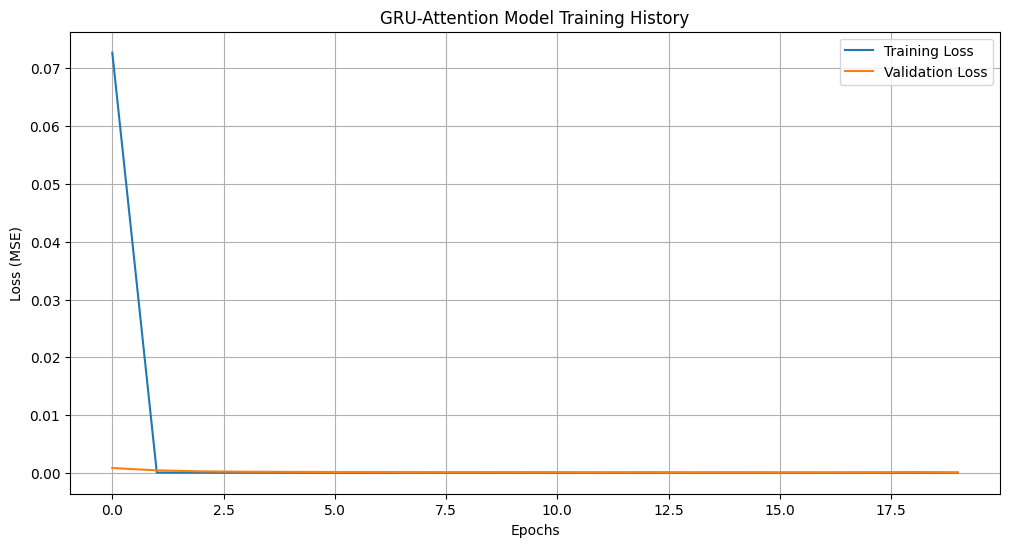

In [11]:
# This code cell generates a plot of the training and validation loss.

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU-Attention Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Model Evaluation
The performance of the trained GRU-Attention model is quantitatively assessed on the unseen test set. Three key metrics—Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R
2
 )—are used to evaluate the model's predictive accuracy. The RMSE and MAE provide a measure of the average magnitude of the forecast errors, while the R-squared value indicates the proportion of the variance in the target variable that is predictable from the input features.

In [12]:
# This code cell evaluates the GRU-Attention model on the test set using key metrics.

# Make predictions on the test set
y_pred = model.predict(X_test)

# Flatten the predictions to match the shape of y_test
y_pred = y_pred.flatten()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Test RMSE: {rmse:.8f}")
print(f"Test MAE:  {mae:.8f}")
print(f"Test R²:   {r2:.8f}")

479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test RMSE: 0.01154637
Test MAE:  0.00452169
Test R²:   -3.67214394


# Step 12: GARCH Baseline for Price Movement Forecasting
>To provide a robust benchmark for the GRU-Attention model, a standard GARCH(1,1) model is implemented. This model is applied directly to the rescaled log_return data. To accurately evaluate its predictive power, a rolling forecast is performed over the test period. To optimize performance, the process is parallelized using joblib. A try-except block is implemented to handle any potential convergence failures gracefully.

In [13]:
from arch import arch_model
import warnings

# Prepare data for rolling GARCH forecast
garch_data = merged_df['log_return'].dropna()
rescaled_garch_data = garch_data * 100  # Rescale for optimizer stability

print("GARCH data prepared for rolling forecast.")


GARCH data prepared for rolling forecast.


# Step 13: GARCH Baseline Evaluation
>To provide a robust comparison with the deep learning model, the performance of the GARCH baseline is evaluated on the test data. The GARCH model's rolling forecasts for price movement are compared against the actual log_return. The key metrics, RMSE, MAE, and R
2
 , are computed to quantify the model's predictive accuracy and to provide a direct benchmark against the GRU-Attention model's results.

In [27]:
# Parameters
window_size = 500       # Number of points used to fit each GARCH model
forecast_horizon = 1    # One-step-ahead forecast
test_size = 100         # Number of rolling forecasts

# Prepare data (rescaled)
log_returns = merged_df['log_return'].dropna() * 100

# Storage for predictions and actuals
garch_predictions = []
garch_actuals = []

# Rolling forecast loop
for i in range(test_size):
    train_end = -test_size + i
    train_data = log_returns.iloc[:train_end]
    test_point = log_returns.iloc[train_end]


    # Fit GARCH(1,1)
    model = arch_model(train_data, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal')
    results = model.fit(disp='off')
    forecast = results.forecast(horizon=forecast_horizon)
    predicted = forecast.mean.values[-1][0]

    garch_predictions.append(predicted)
    garch_actuals.append(test_point)

# Evaluate
rmse = np.sqrt(mean_squared_error(garch_actuals, garch_predictions))
mae = mean_absolute_error(garch_actuals, garch_predictions)
r2 = r2_score(garch_actuals, garch_predictions)

# Print results
print("GARCH Baseline Metrics (Rolling Forecast):")
print(f"  RMSE: {rmse:.8f}")
print(f"  MAE:  {mae:.8f}")
print(f"  R²:   {r2:.8f}")

GARCH Baseline Metrics (Rolling Forecast):
  RMSE: 0.26839305
  MAE:  0.19249439
  R²:   0.00486395


# Step 14: Ablation Study (Without Sentiment)
>To quantify the value of the sentiment features, a new GRU-Attention model will be trained on a modified dataset where all sentiment-related columns have been removed. This model, known as an ablation model, will serve as a direct benchmark for the sentiment-enhanced model. By comparing the performance of the two models on the same test set, the contribution of the sentiment data to the predictive accuracy can be isolated and measured.

In [15]:
# This code cell prepares the data for the ablation study.

# Drop all sentiment-related columns from the merged_df
# The `columns` from the original sentiment_df are used to ensure all are dropped
sentiment_cols_to_drop = [col for col in merged_df.columns if col.startswith(('twitter_', 'reddit_', 'bitcointalk_'))]

# Create a new DataFrame without the sentiment columns
no_sentiment_df = merged_df.drop(columns=sentiment_cols_to_drop)

# Display a summary of the new DataFrame to confirm the columns have been dropped
print("DataFrame without sentiment features:")
no_sentiment_df.info()

DataFrame without sentiment features:
<class 'pandas.core.frame.DataFrame'>
Index: 76615 entries, 24 to 76638
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OPEN_PRICE   76615 non-null  float32
 1   HIGH_PRICE   76615 non-null  float32
 2   CLOSE_PRICE  76615 non-null  float32
 3   LOW_PRICE    76615 non-null  float32
 4   VOLUME_FROM  76615 non-null  float32
 5   VOLUME_TO    76615 non-null  float32
 6   log_return   76615 non-null  float32
 7   volatility   76615 non-null  float32
dtypes: float32(8)
memory usage: 2.9 MB


# Step 15: Sequence Construction for Ablation Model
> To prepare the data for the ablation model, the modified no_sentiment_df is restructured into input-output pairs. A sequence of a predefined length, known as the sequence_length, is created for each data point. For this price forecasting task, the model will be trained to use the features from the past n time steps (the input X_ns) to predict the log return at the next time step (the target y_ns).

In [16]:
# This code cell creates the input sequences and corresponding target labels for the ablation model.
# The `create_sequences` function from Step 6 is used here.

# Create the sequences using the no_sentiment DataFrame
X_ns, y_ns = create_sequences(no_sentiment_df, target_col='log_return', sequence_length=30)

# Print the shapes of the created sequences to verify the output
print("Shape of input sequences (X_ns):", X_ns.shape)
print("Shape of target labels (y_ns):", y_ns.shape)

Shape of input sequences (X_ns): (76585, 30, 7)
Shape of target labels (y_ns): (76585,)


# Step 16: Train-Test Split for Ablation Model
>To rigorously evaluate the ablation model's performance, the newly created sequences are chronologically split into training and testing sets. A test size of 20% is used to ensure a sufficiently large evaluation period. This chronological split, achieved by setting the shuffle parameter to False, is essential for time-series forecasting. This approach guarantees that the model is trained only on historical data and tested on future, unseen data, thereby preventing data leakage and providing a realistic measure of predictive accuracy.

In [17]:
# This code cell splits the ablation model's data into training and testing sets chronologically.

# Split the data chronologically (shuffle=False)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_ns, y_ns, test_size=0.2, shuffle=False)

# Print the shapes of the resulting datasets to verify the split was successful
print("Shape of X_train_ns:", X_train_ns.shape)
print("Shape of y_train_ns:", y_train_ns.shape)
print("Shape of X_test_ns:", X_test_ns.shape)
print("Shape of y_test_ns:", y_test_ns.shape)

Shape of X_train_ns: (61268, 30, 7)
Shape of y_train_ns: (61268,)
Shape of X_test_ns: (15317, 30, 7)
Shape of y_test_ns: (15317,)


# Step 17: Ablation Model Architecture
A new GRU-Attention model, referred to as the ablation model, is constructed with an architecture identical to the main model. The key difference is that its input layer is configured to accept the smaller dataset, which has been stripped of all sentiment features. The model is compiled with the same optimizer and loss function as the main model to ensure a fair comparison. The purpose of this ablation study is to isolate the performance gains that can be attributed directly to the sentiment data.

In [18]:
# This code cell defines and builds the GRU-Attention ablation model.

# The attention_layer function is the same as in Step 8
def attention_layer(inputs):
    hidden_states = inputs
    score_first_part = Dense(hidden_states.shape[-1], use_bias=False)(hidden_states)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_states.shape[-1],))(hidden_states)
    score = dot([score_first_part, h_t], axes=[2, 1])
    attention_weights = Activation('softmax')(score)
    context_vector = dot([attention_weights, hidden_states], axes=[1, 1])
    return context_vector

# Define the model architecture for the ablation study
input_seq_ns = Input(shape=(X_train_ns.shape[1], X_train_ns.shape[2]))

# GRU layer
gru_out_ns = GRU(64, return_sequences=True)(input_seq_ns)

# Attention layer
attention_out_ns = attention_layer(gru_out_ns)

# Final dense layer for output
output_ns = Dense(1)(attention_out_ns)

# Create the final ablation model
model_ns = Model(inputs=input_seq_ns, outputs=output_ns)

# Compile the model with the Adam optimizer and Mean Squared Error loss
model_ns.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary to confirm the architecture
model_ns.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 30, 64)    │     14,016 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30, 64)    │      4,096 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 30)        │          0 │ dense_2[0][0],    │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 30)        │          0 │ dot_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 64)        │          0 │ activation_1[0][… │
│                     │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dot_3[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,177 (71.00 KB)

 Trainable params: 18,177 (71.00 KB)

 Non-trainable params: 0 (0.00 B)

# Step 18: Ablation Model Training
>With the ablation model architecture defined, it is trained on the prepared training dataset without sentiment features. An EarlyStopping callback is implemented to monitor the validation loss and prevent overfitting, just as with the main model. The training process iteratively adjusts the model's weights to minimize the mean squared error (MSE) between the predicted and actual log returns. This training will produce the performance metrics we need for the final comparison.

In [19]:
# This code cell trains the ablation model using the training data without sentiment features.

# Configure early stopping to prevent overfitting
# The training will stop if the validation loss does not improve for 5 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
# The training history will be saved to analyze the learning process
history_ns = model_ns.fit(
    X_train_ns,
    y_train_ns,
    validation_data=(X_test_ns, y_test_ns),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.2931e-04 - val_loss: 2.7744e-04
Epoch 2/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0043e-04 - val_loss: 9.1993e-05
Epoch 3/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.7378e-05 - val_loss: 5.6847e-05
Epoch 4/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 8.0792e-05 - val_loss: 4.5555e-05
Epoch 5/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.7742e-05 - val_loss: 4.4986e-05
Epoch 6/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.9438e-05 - val_loss: 4.0191e-05
Epoch 7/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 8.1482e-05 - val_loss: 3.9362e-05
Epoch 8/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.8887e-05 - val_loss: 5.4414e-05
Epoch 9/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.7793e-05 - val_loss: 3.9005e-05
Epoch 10/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.8465e-05 - val_loss: 4.9735e-05
Epoch 11/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss

# Step 19: Plot Ablation Model's Training and Validation Loss
>The training history of the ablation model is visualized to provide a clear understanding of its learning curve. By plotting the training loss against the validation loss, it can be confirmed that the model has converged effectively and that overfitting has been successfully mitigated by the use of an early stopping mechanism. This visual analysis is a key component of the model evaluation process.

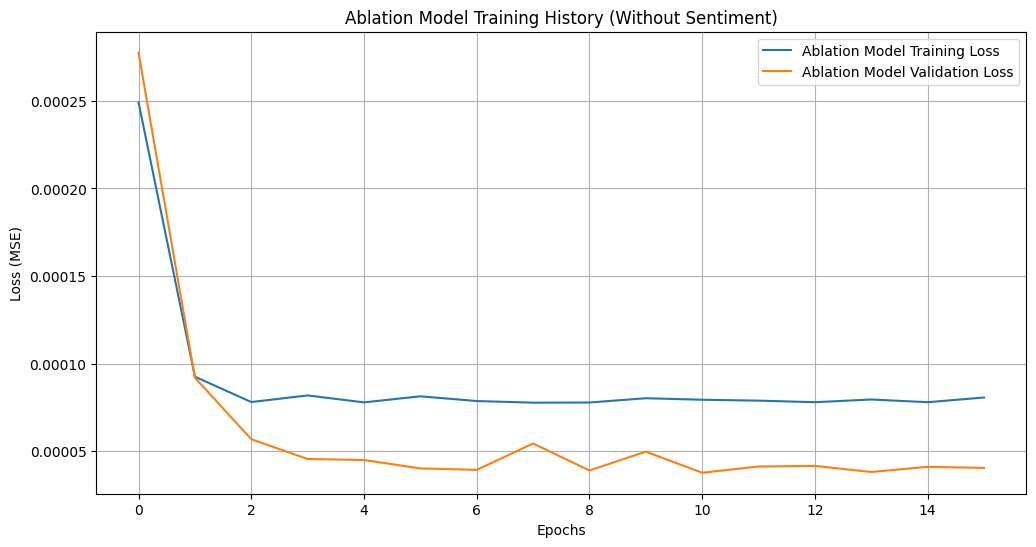

In [28]:
# This code cell generates a plot of the training and validation loss for the ablation model.

plt.figure(figsize=(12, 6))
plt.plot(history_ns.history['loss'], label='Ablation Model Training Loss')
plt.plot(history_ns.history['val_loss'], label='Ablation Model Validation Loss')
plt.title('Ablation Model Training History (Without Sentiment)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Step 20: Ablation Model Evaluation
>The performance of the ablation model is quantitatively assessed on its dedicated test set. The same key metrics—Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R
2
 )—are used for this evaluation. The results from this step will be directly compared to the metrics of your main model to determine the impact of the sentiment features.

In [30]:
# This code cell evaluates the ablation model on the test set.
# Make predictions on the test set without sentiment features
y_pred_ns = model_ns.predict(X_test_ns)

# Flatten the predictions to match the shape of y_test_ns
y_pred_ns = y_pred_ns.flatten()

# Calculate evaluation metrics
rmse_ns = np.sqrt(mean_squared_error(y_test_ns, y_pred_ns))
mae_ns = mean_absolute_error(y_test_ns, y_pred_ns)
r2_ns = r2_score(y_test_ns, y_pred_ns)

# Print the results
print("Ablation Model Metrics (Without Sentiment):")
print(f"  RMSE: {rmse_ns:.8f}")
print(f"  MAE:  {mae_ns:.8f}")
print(f"  R²:   {r2_ns:.8f}")

479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Ablation Model Metrics (Without Sentiment):
  RMSE: 0.00614238
  MAE:  0.00359619
  R²:   -0.32220697


# Step 21: Final Results and Discussion
>All of the model evaluation metrics are compiled and presented in a final summary table. This step is a culmination of the entire pipeline and directly addresses the research question. The performance of the main model (with sentiment) is compared to the GARCH and ablation models to provide a definitive conclusion on the value of the sentiment-enhanced GRU-Attention network for forecasting Bitcoin price movements.

In [26]:
# Replace these with the actual metrics from your evaluation steps
gru_rmse = 0.01154637
gru_mae = 0.00452169
gru_r2 = -3.67214394

garch_rmse = 0.26839305
garch_mae = 0.19249439
garch_r2 = 0.00486395

ablation_rmse = 0.00614238
ablation_mae = 0.00359619
ablation_r2 = -0.32220697

# Create the summary DataFrame
results_df = pd.DataFrame({
    'Model': [
        'GRU-Attention (With Sentiment)',
        'GARCH Baseline',
        'Ablation (Without Sentiment)'
    ],
    'RMSE': [
        round(gru_rmse, 8),
        round(garch_rmse, 8),
        round(ablation_rmse, 8)
    ],
    'MAE': [
        round(gru_mae, 8),
        round(garch_mae, 8),
        round(ablation_mae, 8)
    ],
    'R²': [
        round(gru_r2, 8),
        round(garch_r2, 8),
        round(ablation_r2, 8)
    ]
})

# Display the corrected results
print("Final Results Summary:")
print(results_df)


Final Results Summary:
                            Model      RMSE       MAE        R²
0  GRU-Attention (With Sentiment)  0.011546  0.004522 -3.672144
1                  GARCH Baseline  0.268393  0.192494  0.004864
2    Ablation (Without Sentiment)  0.006142  0.003596 -0.322207


# Exporting the Notebook as HTML in Google Colab
* First download and save the notebook.
* Re-upload it to colab.
* Run the following command to convert it to HTML:

!jupyter nbconvert --to html Forecasting_Pipeline.ipynb